In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa import arima
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed


In [21]:
# these were to create the texasPowerGrid.csv, using 2018 thru 2022

# JD2015 = pd.read_csv('EIA930_BALANCE_2015_Jul_Dec.csv')
# JJ2016 = pd.read_csv('EIA930_BALANCE_2016_Jan_Jun.csv')
# JD2016 = pd.read_csv('EIA930_BALANCE_2016_Jul_Dec.csv')
# JJ2017 = pd.read_csv('EIA930_BALANCE_2017_Jan_Jun.csv')
# JD2017 = pd.read_csv('EIA930_BALANCE_2017_Jul_Dec.csv')
# JJ2018 = pd.read_csv('EIA930_BALANCE_2018_Jan_Jun.csv')
# JD2018 = pd.read_csv('EIA930_BALANCE_2018_Jul_Dec.csv')
# JJ2019 = pd.read_csv('EIA930_BALANCE_2019_Jan_Jun.csv')
# JD2019 = pd.read_csv('EIA930_BALANCE_2019_Jul_Dec.csv')
# JJ2020 = pd.read_csv('EIA930_BALANCE_2020_Jan_Jun.csv')
# JD2020 = pd.read_csv('EIA930_BALANCE_2020_Jul_Dec.csv')
# JJ2021 = pd.read_csv('EIA930_BALANCE_2021_Jan_Jun.csv')
# JD2021 = pd.read_csv('EIA930_BALANCE_2021_Jul_Dec.csv')
# JJ2022 = pd.read_csv('EIA930_BALANCE_2022_Jan_Jun.csv')
# JD2022 = pd.read_csv('EIA930_BALANCE_2022_Jul_Dec.csv')

In [127]:
# JD2017.columns == JD2018.columns  # 15 cols pre 2018, 24 after

# len(JD2018.columns)

# csvlist = [JJ2018, JD2018, JJ2019, JD2019, JJ2020, JD2020, JJ2021, JD2021, JJ2022, JD2022]

In [128]:
# total = pd.concat(csvlist)

In [129]:
# total.shape

In [8]:
# texas = total.loc[total['Region'] == 'TEX']
texas = pd.read_csv('../Data/texasPowerGrid.csv')

/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
texas.set_index(pd.to_datetime(texas['UTC Time at End of Hour']), inplace=True)

In [10]:
len(texas)

43200

In [232]:
interNoNull = texas['Total Interchange (MW)'].dropna()
interFloat = interNoNull.str.replace(',', '').astype(float)
iFMean = interFloat.rolling(window=120).mean()

In [233]:
iFMean

UTC Time at End of Hour
2018-01-01 07:00:00          NaN
2018-01-01 08:00:00          NaN
2018-01-01 09:00:00          NaN
2018-01-01 10:00:00          NaN
2018-01-01 11:00:00          NaN
                         ...    
2022-12-05 02:00:00    64.750000
2022-12-05 03:00:00    61.641667
2022-12-05 04:00:00    58.533333
2022-12-05 05:00:00    54.916667
2022-12-05 06:00:00    51.666667
Name: Total Interchange (MW), Length: 43075, dtype: float64

In [234]:
# texas.to_csv('./texasPowerGrid.csv') # saving the dataframe as a csv to be used from now on

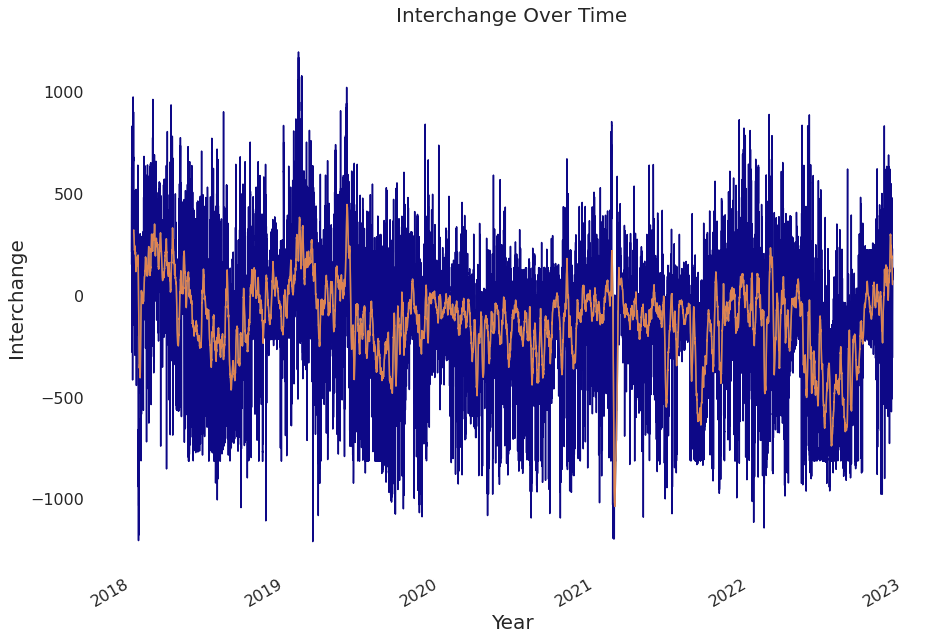

In [235]:
interFloat.plot(figsize=(15,11), colormap='plasma', ylabel='Interchange', 
                xlabel='', fontsize=16 );iFMean.plot()
iFMean.plot()
plt.title('Interchange Over Time', fontsize=20)
plt.ylabel('Interchange', fontsize=20)
plt.xlabel('Year', fontsize=20)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

### 2021 Texas Power Crisis clearly visible in the graph:

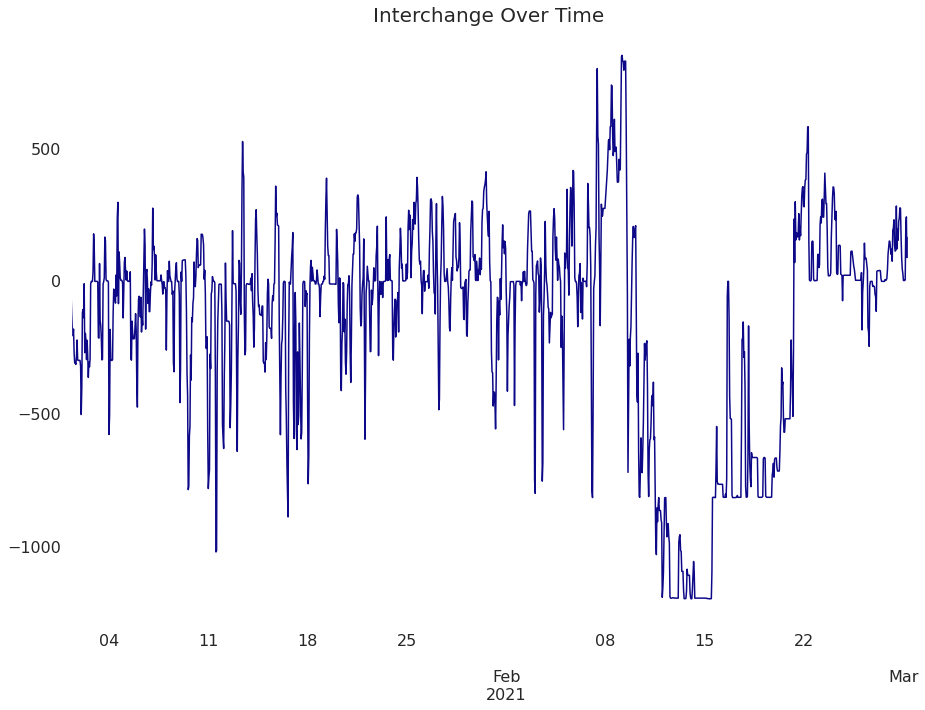

In [77]:
interFloat['2021-01-01 07:00:00':'2021-03-01 07:00:00'].plot(figsize=(15,11), title='Interchange Over Time', colormap='plasma',
                                                             ylabel='', xlabel='', fontsize=16 )
plt.title('Interchange Over Time', fontsize=20)
rc={'axes.facecolor':'white', 'figure.facecolor':'white'}

In [238]:
smx0 = sarimax.SARIMAX(interFloat, order=(1,0,1), seasonal_order=(1,0,1,24)).fit()


In [33]:
forc0 = smx0.forecast(steps=50)

/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:ylabel='Count'>

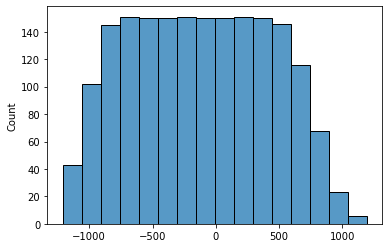

In [145]:
max(interFloat), min(interFloat)
valRange = [int(i) for i in set(interFloat)]
valRange.sort()
sns.histplot(valRange)

In [13]:
cutoff = round(interFloat.shape[0]*0.8)
cutoff

train = interFloat[:cutoff]

test = interFloat[cutoff:] 

(<AxesSubplot:xlabel='UTC Time at End of Hour'>,
 <AxesSubplot:xlabel='UTC Time at End of Hour'>)

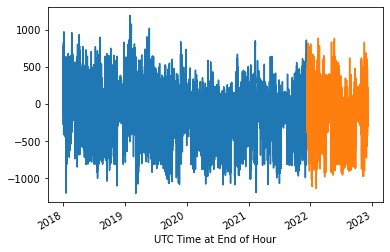

In [14]:
train.plot(), test.plot()

<AxesSubplot:ylabel='Count'>

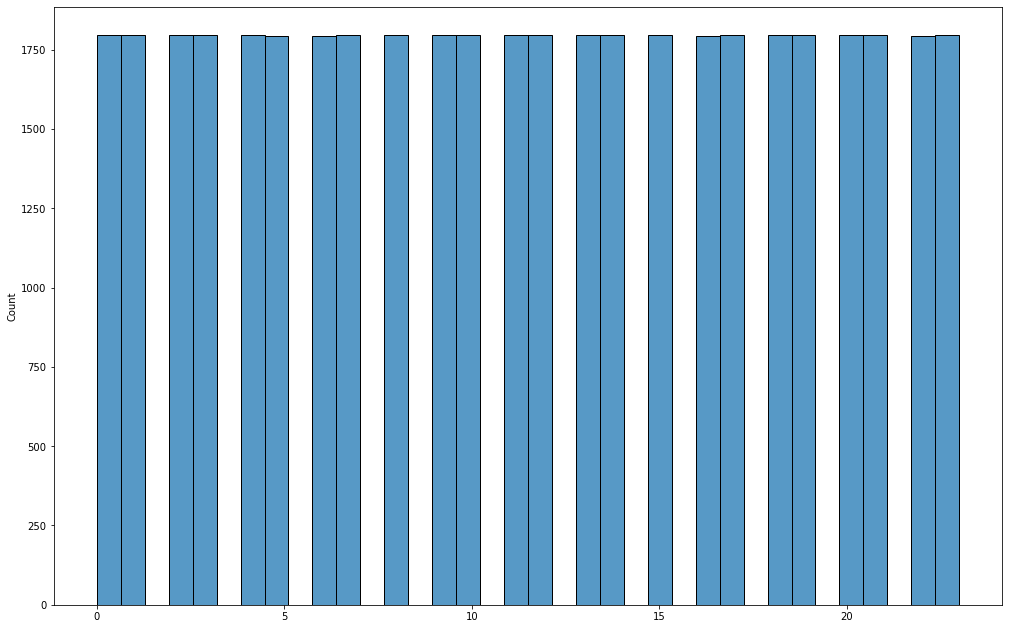

In [15]:
timestamp = [str(stamp) for stamp in interFloat.index]
hrs = []
for i in range(len(timestamp)):
    hrs.append(int(timestamp[i][-8:-6]))

fig, ax = plt.subplots(figsize=(17, 11))
sns.histplot(hrs) # this shows why the frequency error was happening with sarimax; missing hours


In [16]:
texas[['Demand Forecast (MW)','Net Generation (MW) from Other Fuel Sources']]

,Demand Forecast (MW),Net Generation (MW) from Other Fuel Sources
UTC Time at End of Hour,,
2018-01-01 07:00:00,"47,834",NaN
2018-01-01 08:00:00,"48,313",NaN
2018-01-01 09:00:00,"49,513",NaN
2018-01-01 10:00:00,"48,663",NaN
2018-01-01 11:00:00,"50,639",NaN
...,...,...
2022-12-06 02:00:00,"45,525",NaN
2022-12-06 03:00:00,"44,590",NaN
2022-12-06 04:00:00,"43,224",NaN


In [17]:
trainD = train.resample('D').mean()
testD = test.resample('D').mean()

In [35]:
smx1 = sarimax.SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,24)).fit()


/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [9]:
smx1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             Total Interchange (MW)   No. Observations:                34460
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -215590.930
Date:                            Tue, 06 Dec 2022   AIC                         431191.860
Time:                                    14:45:12   BIC                         431234.098
Sample:                                         0   HQIC                        431205.324
                                          - 34460                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8544      0.003    303.155      0.000       0.849       0.860
ma.L1          0.0853      0.005     16.479      0.000       0.075       0.095
ar.S.L24       0.9752      0.002    636.654      0.000       0.972       0.978
ma.S.L24      -0.8887      0.003   -286.571      0.000      -0.895      -0.883
sigma2       1.59e+04     76.269    208.504      0.000    1.58e+04    1.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             19219.92
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
smx2 = sarimax.SARIMAX(trainD, order=(1,2,2), seasonal_order=(0,1,1,7)).fit()

/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
y_hat_test = smx2.predict(start='2021-12-11', end='2022-12-05', typ='levels')
y_hat_train = smx2.predict(typ='levels')

NameError: name 'smx2' is not defined

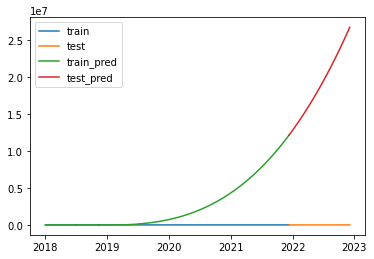

In [15]:
fig, ax = plt.subplots()
ax.plot(trainD, label='train')
ax.plot(testD, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

In [46]:
smx1.predict(start='2021-12-11', end='2022-12-05', typ='levels')

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

For sklearn like n_jobs, could import joblib.Parallel, which is what sklearn uses. Doesn't seem super difficult (famous last words?)

In [19]:
smxes = Parallel(n_jobs=2, verbose=100, pre_dispatch='1.5*n_jobs')(
               delayed(sarimax.SARIMAX)(train, order=(i, 0, j),
               seasonal_order=(i, 0, j, 24)) for i, j in zip(range(0, 3), range(0, 3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.8s finished


In [20]:
365/4

91.25

In [ ]:
for i in smxes:
    i.fit()
# convergence error, kernel crash. is there a way to do this?

/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# from https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b , doesn't seem to work
# import itertools
# # import statsmodels.api as sm

# ### Define Parameter Ranges to Test ###
# # Note: higher numbers will result in code taking much longer to run
# # Here we have it set to test p,d,q each = 0, 1 & 2
# # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
# p = d = q = range(0, 3)
# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))
# # Generate all different combinations of seasonal p, q and q triplets
# # Note: here we have 12 in the 's' position as we have monthly data
# # You'll want to change this according to your time series' frequency
# pdqs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
# ### Run Grid Search ###
# # Note: this code will take a while to run
# # Define function
# def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='H'):
#     '''
#     Input:
#         ts : your time series data
#         pdq : ARIMA combinations from above
#         pdqs : seasonal ARIMA combinations from above
#         maxiter : number of iterations, increase if your model isn't converging
#         frequency : default='M' for month. Change to suit your time series frequency
#             e.g. 'D' for day, 'H' for hour, 'Y' for year.
#     Return:
#         Prints out top 5 parameter combinations
#         Returns dataframe of parameter combinations ranked by AIC
#     '''
#     # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
#     ans = []
#     for comb in pdq:
#         for combs in pdqs:
#             try:
#                 mod = sarima.SARIMAX(ts, # this is your time series you will input
#                                                 order=comb,
#                                                 seasonal_order=combs,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False,
#                                                 freq=freq)
#                 output = mod.fit(maxiter=maxiter)
#                 ans.append([comb, combs, output.aic])
#                 print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#             except:
#                 continue
#     # Find the parameters with minimal BIC value
#     # Convert into dataframe
# #     ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
#     # Sort and return top 5 combinations
# #     ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:5]
# #     return ans_df
# ### Apply function to your time series data ###
# # Remember to change frequency to match your time series data

# sarimax_gridsearch(train, pdq, pdqs, freq='H')

In [31]:
# getting a time estimate for the grid searches that Andrew and Juan are running.
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
# # Generate all different combinations of seasonal p, q and q triplets
# # Note: here we have 12 in the 's' position as we have monthly data
# # You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 24 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
print((len(pdqs) * len(pdqs2)))

216


In [2]:
# # this one crashes my kernel every time I try running it 

# import statsmodels.api as sm
# import itertools
# # Grid Search
# p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
# pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
# p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
# pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
# s = 24 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
# pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
# combs = {}
# mses = []
# # Grid Search Continued
# for combination in pdq:
#     for seasonal_combination in pdqs2:
#         try:
#             model = sm.tsa.statespace.SARIMAX(train, order=combination, seasonal_order=seasonal_combination,
#                                              enforce_stationarity=False,
#                                              enforce_invertibility=False)
#             model = model.fit()
#             combs.update({model.mse : [combination, seasonal_combination]})
#             mses.append(model.mse)
            
#         except:
#             continue
            
# best_mse = min(mses)
# # Modeling and forcasting
# model = sm.tsa.statespace.SARIMAX(train, order=combs[best_mse][0], seasonal_order=combs[best_mse][1],
#                                              enforce_stationarity=False,
#                                              enforce_invertibility=False)
# model = model.fit()
# model.forecast(7)

In [17]:
smx.predict

pandas.core.series.Series

In [237]:
# len(train)/2, len(test)/2
X_train = train[:17230]
X_test = train[17230:]
y_train = test[4308:]
y_test = test[:4308]
#have to do train test split in a better way than the above

# boost = xgb.XGBRegressor(n_estimators=1000)
# boost.fit(X_train.to_frame(), y_train.to_frame(),
#         eval_set=[(X_train.to_frame(), y_train.to_frame()), (X_test.to_frame(), y_test.to_frame())],
#         early_stopping_rounds=50,
#        verbose=True)

In [ ]:
# it looks like xgboost isn't feasible with the time constraints. Andrew is adding weather data, 
# TODO: make another SARIMA with eXogenous variables, weather and energy source type (coal, wind, ...)

In [20]:
el_paso_weather = pd.read_csv('../Data/El_Paso_Weather.csv')
corpus_christi_weather = pd.read_csv('../Data/Corpus_Christi_Weather.csv')
dallas_weather = pd.read_csv('../Data/Dallas_Weather.csv')
amarillo_weather = pd.read_csv('../Data/Amarillo_Weather.csv')

# list of weather station dataframes
weather_station_list = [el_paso_weather, corpus_christi_weather, dallas_weather, amarillo_weather]

for station in weather_station_list:
    station.set_index(pd.to_datetime(station['DATE']), inplace=True)  

In [21]:
# compiling new weather dataframe with only columns of interest from each station
weather = pd.DataFrame()
weather['el_paso_AWND'] = el_paso_weather['AWND']
weather['corpus_christi_AWND'] = corpus_christi_weather['AWND']
weather['dallas_AWND'] = dallas_weather['AWND']
weather['amarillo_AWND'] = amarillo_weather['AWND']
weather['el_paso_PRCP'] = el_paso_weather['PRCP']
weather['corpus_christi_PRCP'] = corpus_christi_weather['PRCP']
weather['dallas_PRCP'] = dallas_weather['PRCP']
weather['amarillo_PRCP'] = amarillo_weather['PRCP']
weather['el_paso_SNOW'] = el_paso_weather['SNOW']
weather['corpus_christi_SNOW'] = corpus_christi_weather['SNOW']
weather['dallas_SNOW'] = dallas_weather['SNOW']
weather['amarillo_SNOW'] = amarillo_weather['SNOW']
weather['el_paso_TMAX'] = el_paso_weather['TMAX']
weather['corpus_christi_TMAX'] = corpus_christi_weather['TMAX']
weather['dallas_TMAX'] = dallas_weather['TMAX']
weather['amarillo_TMAX'] = amarillo_weather['TMAX']
weather['el_paso_TMIN'] = el_paso_weather['TMIN']
weather['corpus_christi_TMIN'] = corpus_christi_weather['TMIN']
weather['dallas_TMIN'] = dallas_weather['TMIN']
weather['amarillo_TMIN'] = amarillo_weather['TMIN']

In [22]:
# copying and pasting Andrew's model results to try to find switching points
best_model_preds = [61.41287342340463, -23.489853245925133, 75.52340245490831, 44.50277688548461, -40.14049600349681, -50.61663450770365, -73.61816629231484, 28.305032598862738, 0.1683994444377106, -6.00576849182298, 123.93290068107535, 70.44675315836756, 6.867012047924476, -16.40406149176121, -9.975290344497086, 0.5509176949924779, -66.51918514352387, -96.94280141771989, -33.42392298072693, -81.56454733667128, -47.79001243397826, -60.37055873406493, -14.478755714766692, 1.357326306943122, 250.7765947498322, 254.50707044920492, 11.117882239586748, -31.466168178050722, -4.656330934179266, 160.1217315766003, 75.84140001724704, -119.08703517090943, 43.56931349666347, 45.0671852579472, -23.87179440709849, -61.508215485014176, -60.3896922203259, -11.4463776638474, 162.95428090212187, 80.03617286565927, 45.68468156155293, 2.0586487568697827, 163.57690294227925, 208.46198781370245, 102.45923205651377, 47.471666684523626, -5.037553431181109, -22.13654493364882, 18.822046514399048, 55.26606061753543, -3.610865309830082, 22.407001846119933, 8.98694579240686, -28.374211630423652, -52.89249869433334, -132.7647767402203, 167.57001507141405, 156.90424326418707, 190.79341930097814, 93.52293732633012, -23.010330179183008, 19.692121183935257, 10.529339320741464, -78.13590995818056, -143.35433252706775, -95.73544693703889, 79.08019489803985, -5.162936951883438, -14.070445301129165, 43.119440144237274, 95.07049334388849, 199.49214083473703, 99.23633699091491, 4.969699457043582, -2.993400292250879, 112.31859853741025, 187.66250991469548, 168.27023054206558, 185.17397933401992, 31.62657797545355, -15.851833566272674, 23.357956919234866, -28.86361148515906, -126.22715637222842, -156.56563571020203, -126.04989946406104, -69.67057904325995, -55.00178358769186, 97.30167017086819, 112.64025505774599, 15.868511394991202, 29.36323204289606, -1.8933081458543697, 151.76066272726175, -8.930049820468938, 19.52090235154469, -54.11557093899461, 14.582540690870548, -77.33300159002316, 30.528344670145785, 49.2540569574182, -8.568433406307896, -54.678285932476555, 221.94386801935983, 99.71414607839311, -26.93721815498902, 23.184114027172527, -115.9187316069127, -26.270635693892988, -109.69758492763259, -41.22902096786259, 30.826983448903192, 139.19646482864488, -29.18549276282338, -56.164293522476925, -67.00523143328564, -136.02708085446716, -90.45520780792265, -83.45218157151149, 0.32435310691672825, -57.5225142195891, -57.56827103524028, 34.914751913902826, -38.397811525867425, -108.2505878930485, -29.297371022071815, -14.540561960054518, 49.16384400291632, -56.231843484391916, -53.8042981060512, -22.233560443188352, -26.814238427240713, -27.98108108498615, -83.53574864076327, -42.15035372819527, -92.28104089222566, -48.01250521329469, -4.302889965772991, 23.10561882976714, -64.42352336827645, -141.59609285220284, -134.80784962012186, -68.93249947862651, -120.36509358423649, -126.97053146277324, -10.591920282401738, -47.05605872864841, -115.53207522008782, -80.22834358572766, -84.52589381867303, -136.95313235171005, -155.26469646668895, -131.929371457593, -180.8650818927722, -255.3135821478961, -251.2572568941818, -207.68827237508395, -169.20123074279658, -166.28847762139986, -201.85292521589875, -166.4769458070805, -148.6564064882591, -81.89081388831866, -68.41774058541978, -79.08306996856453, -59.63524201646045, -157.38717234430618, -120.92509894409113, -72.17022146161452, -194.42470457628883, -214.36697385210422, -212.66711805261292, -129.3766118202326, -136.7836563623813, -221.78641442548326, -213.33979086526614, -233.6188382821574, -296.48836571133864, -239.23664324163133, -206.01453956418044, -236.57137465797433, -297.7563000432316, -228.26052133121667, -303.9139759051679, -353.99599697026895, -330.6973241172556, -282.5895663269531, -249.8897930531188, -203.7627165381358, -263.073336345978, -314.4094044382875, -311.5745690116526, -291.325808628884, -286.96944704987635, -279.51341392741745, -256.2808645648819, -284.41372865905123, -344.7244690332453, -307.03873508239957, -343.98435034231215, -326.1377393987045, -269.00544745793627, -252.91155299196723, -267.4410797153548, -325.6134661351357, -311.7657329213208, -291.8264703615663, -364.1254103455814, -306.22926211598303, -281.61192627950066, -357.37100047656963, -364.15694730734003, -350.67203862501367, -381.9636292627509, -393.0004985629224, -333.66226439826073, -321.95200902718864, -332.0325587752619, -296.69705588512613, -313.5499094771617, -267.55104910891504, -318.8234151437254, -328.94395611865644, -300.98771602682126, -297.56693568930353, -320.4891802448268, -304.4092700795052, -299.35727735278454, -256.2962416265757, -322.5336568185796, -328.65113432243413, -335.727573426038, -283.27132511663586, -250.32725797448842, -325.70785375240837, -354.121455623505, -363.2517598444134, -310.95315440596744, -284.21846280110213, -266.79038188016466, -363.4712811418323, -353.6582368752027, -310.89809597014823, -394.62212958415495, -401.32875908506855, -375.1567261294665, -331.50623026890474, -290.1944499898853, -305.05293388398263, -311.0655814319884, -270.39030924875135, -310.6221777650785, -245.7098337020907, -273.61044461436956, -237.3565019515174, -244.70499240466972, -219.06402937722333, -150.1333415900835, -234.00553088511825, -279.7409000870701, -333.3462532949557, -319.95469515673284, -288.0047072628492, -290.1126862812487, -306.6814294609454, -296.5669912194481, -320.86144620122604, -318.66178853089707, -294.2974245094209, -301.2555365905386, -348.2907303532428, -323.32514656524825, -321.2771873507159, -313.8287565317088, -344.0611001699498, -314.230686791526, -282.50141176126454, -201.98427873176868, -211.60466951037986, -246.50621477157858, -224.26124116713206, -197.56979575898714, -244.5810393790139, -248.08918002559238, -252.9349139587347, -285.10199378462175, -313.56871759284206, -302.4261193294021, -255.9680938501032, -255.78529203747686, -338.322439872554, -306.7798441961202, -184.567010888744, -181.6931124452441, -272.8908265651288, -220.37461635951044, -200.67925216363778, -249.02206765334358, -216.59027554507483, -203.9473603502742, -267.29619400781223, -289.6969926542419, -248.3110046080976, -256.29673203989614, -239.9414941144713, -189.95482247394062, -207.59290465341098, -157.71890951216167, -220.09503599928658, -138.17936704077414, -96.50310026063781, -169.64193914008698, -146.79919142132826, -89.44227110008012, -158.72811030455617, -103.71872237320056, -187.31323127632703, -155.78521129700005, -136.8498622909156, -159.25407260458513, 68.49929505853937, -85.94336826132604, -80.51057025430278, -90.7463225749006, -92.25943641617849, -141.32779670674097, -180.91281900832627, -196.67751808109853, -118.32097074021307, -145.51848032685947, -178.7565934155952, 102.16550482800255, 8.166342309169785, -170.92416714765682, -184.12133761619577, -232.55312732690174, -225.83818116202337, -122.21032584146779, 78.29595613073775, 48.303413920368854, 22.694907310243053, 35.59935436190577, 28.812597612398545, -49.149071398161915, 2.2966058450412774, 15.555764038366782, 85.80241299211113, 16.547880356230372, 13.229764106716722, -61.1566278949528, -72.86466529394067, -87.08379810194705, -8.827129515474066, -51.33796182418117, -139.21538544847851, -41.54657036912063, 39.83886884138102, 24.968045755653463,-5.666317371761835]

In [23]:
times = ['2021-12-08','2021-12-09','2021-12-10','2021-12-11','2021-12-12','2021-12-13','2021-12-14','2021-12-15','2021-12-16','2021-12-17','2021-12-18','2021-12-19','2021-12-20','2021-12-21','2021-12-22','2021-12-23','2021-12-24','2021-12-25','2021-12-26','2021-12-27','2021-12-28','2021-12-29','2021-12-30','2021-12-31','2022-01-01','2022-01-02','2022-01-03','2022-01-04','2022-01-05','2022-01-06','2022-01-07','2022-01-08','2022-01-09','2022-01-10','2022-01-11','2022-01-12','2022-01-13','2022-01-14','2022-01-15','2022-01-16','2022-01-17','2022-01-18','2022-01-19','2022-01-20','2022-01-21','2022-01-22','2022-01-23','2022-01-24','2022-01-25','2022-01-26','2022-01-27','2022-01-28','2022-01-29','2022-01-30','2022-01-31','2022-02-01','2022-02-02','2022-02-03','2022-02-04','2022-02-05','2022-02-06','2022-02-07','2022-02-08','2022-02-09','2022-02-10','2022-02-11','2022-02-12','2022-02-13','2022-02-14','2022-02-15','2022-02-16','2022-02-17','2022-02-18','2022-02-19','2022-02-20','2022-02-21','2022-02-22','2022-02-23','2022-02-24','2022-02-25','2022-02-26','2022-02-27','2022-02-28','2022-03-01','2022-03-02','2022-03-03','2022-03-04','2022-03-05','2022-03-06','2022-03-07','2022-03-08','2022-03-09','2022-03-10','2022-03-11','2022-03-12','2022-03-13','2022-03-14','2022-03-15','2022-03-16','2022-03-17','2022-03-18','2022-03-19','2022-03-20','2022-03-21','2022-03-22','2022-03-23','2022-03-24','2022-03-25','2022-03-26','2022-03-27','2022-03-28','2022-03-29','2022-03-30','2022-03-31','2022-04-01','2022-04-02','2022-04-03','2022-04-04','2022-04-05','2022-04-06','2022-04-07','2022-04-08','2022-04-09','2022-04-10','2022-04-11','2022-04-12','2022-04-13','2022-04-14','2022-04-15','2022-04-16','2022-04-17','2022-04-18','2022-04-19','2022-04-20','2022-04-21','2022-04-22','2022-04-23','2022-04-24','2022-04-25','2022-04-26','2022-04-27','2022-04-28','2022-04-29','2022-04-30','2022-05-01','2022-05-02','2022-05-03','2022-05-04','2022-05-05','2022-05-06','2022-05-07','2022-05-08','2022-05-09','2022-05-10','2022-05-11','2022-05-12','2022-05-13','2022-05-14','2022-05-15','2022-05-16','2022-05-17','2022-05-18','2022-05-19','2022-05-20','2022-05-21','2022-05-22','2022-05-23','2022-05-24','2022-05-25','2022-05-26','2022-05-27','2022-05-28','2022-05-29','2022-05-30','2022-05-31','2022-06-01','2022-06-02','2022-06-03','2022-06-04','2022-06-05','2022-06-06','2022-06-07','2022-06-08','2022-06-09','2022-06-10','2022-06-11','2022-06-12','2022-06-13','2022-06-14','2022-06-15','2022-06-16','2022-06-17','2022-06-18','2022-06-19','2022-06-20','2022-06-21','2022-06-22','2022-06-23','2022-06-24','2022-06-25','2022-06-26','2022-06-27','2022-06-28','2022-06-29','2022-06-30','2022-07-01','2022-07-02','2022-07-03','2022-07-04','2022-07-05','2022-07-06','2022-07-07','2022-07-08','2022-07-09','2022-07-10','2022-07-11','2022-07-12','2022-07-13','2022-07-14','2022-07-15','2022-07-16','2022-07-17','2022-07-18','2022-07-19','2022-07-20','2022-07-21','2022-07-22','2022-07-23','2022-07-24','2022-07-25','2022-07-26','2022-07-27','2022-07-28','2022-07-29','2022-07-30','2022-07-31','2022-08-01','2022-08-02','2022-08-03','2022-08-04','2022-08-05','2022-08-06','2022-08-07','2022-08-08','2022-08-09','2022-08-10','2022-08-11','2022-08-12','2022-08-13','2022-08-14','2022-08-15','2022-08-16','2022-08-17','2022-08-18','2022-08-19','2022-08-20','2022-08-21','2022-08-22','2022-08-23','2022-08-24','2022-08-25','2022-08-26','2022-08-27','2022-08-28','2022-08-29','2022-08-30','2022-08-31','2022-09-01','2022-09-02','2022-09-03','2022-09-04','2022-09-05','2022-09-06','2022-09-07','2022-09-08','2022-09-09','2022-09-10','2022-09-11','2022-09-12','2022-09-13','2022-09-14','2022-09-15','2022-09-16','2022-09-17','2022-09-18','2022-09-19','2022-09-20','2022-09-21','2022-09-22','2022-09-23','2022-09-24','2022-09-25','2022-09-26','2022-09-27','2022-09-28','2022-09-29','2022-09-30','2022-10-01','2022-10-02','2022-10-03','2022-10-04','2022-10-05','2022-10-06','2022-10-07','2022-10-08','2022-10-09','2022-10-10','2022-10-11','2022-10-12','2022-10-13','2022-10-14','2022-10-15','2022-10-16','2022-10-17','2022-10-18','2022-10-19','2022-10-20','2022-10-21','2022-10-22','2022-10-23','2022-10-24','2022-10-25','2022-10-26','2022-10-27','2022-10-28','2022-10-29','2022-10-30','2022-10-31','2022-11-01','2022-11-02','2022-11-03','2022-11-04','2022-11-05','2022-11-06','2022-11-07','2022-11-08','2022-11-09','2022-11-10','2022-11-11','2022-11-12','2022-11-13','2022-11-14','2022-11-15','2022-11-16','2022-11-17','2022-11-18','2022-11-19','2022-11-20','2022-11-21','2022-11-22','2022-11-23','2022-11-24','2022-11-25','2022-11-26','2022-11-27','2022-11-28','2022-11-29','2022-11-30','2022-12-01']

In [34]:
predictions0 = pd.DataFrame(best_model_preds, times, columns=['Predictions'])

In [36]:
predictions0

,Predictions
2021-12-08,61.412873
2021-12-09,-23.489853
2021-12-10,75.523402
2021-12-11,44.502777
2021-12-12,-40.140496
...,...
2022-11-27,-139.215385
2022-11-28,-41.546570
2022-11-29,39.838869
2022-11-30,24.968046


In [92]:
andrewTestD = [-99.58333333333333, 68.375, 56.916666666666664, 138.625, 37.958333333333336, 148.125, 68.83333333333333, 108.375, -20.166666666666668, 44.958333333333336, -108.54166666666667, 19.25, -206.25, 31.208333333333332, 213.04166666666666, -71.375, 63.0, -132.125, -187.91666666666666, -85.66666666666667, -147.08333333333334, 82.16666666666667, -158.375, -382.625, -155.29166666666666, 162.875, 152.16666666666666, 131.20833333333334, 131.375, -158.33333333333334, -233.58333333333334, -250.375, -292.9583333333333, 2.4583333333333335, -304.2083333333333, -78.70833333333333, -180.375, -110.83333333333333, 318.8333333333333, -46.083333333333336, -80.79166666666667, 216.08333333333334, 65.91666666666667, 84.33333333333333, -205.04166666666666, 233.54166666666666, -80.0, -57.666666666666664, -133.625, -120.83333333333333, -186.16666666666666, -61.125, -190.5, 146.04166666666666, -95.58333333333333, -297.5, -77.20833333333333, -429.5, -840.6666666666666, -743.9583333333334, -257.0833333333333, 18.166666666666668, -247.5, -128.29166666666666, -63.166666666666664, -208.70833333333334, 103.625, -332.25, -167.125, 186.41666666666666, 513.0, 400.3333333333333, 26.083333333333332, -18.375, 32.833333333333336, 340.8333333333333, 300.75, 247.625, -560.5416666666666, -403.9583333333333, -407.5833333333333, -252.41666666666666, -276.1666666666667, -140.5, -133.70833333333334, -293.625, -31.25, 236.91666666666666, 10.083333333333334, 17.458333333333332, -431.1666666666667, -512.1666666666666, -362.5833333333333, -74.25, -409.1666666666667, 33.25, 102.29166666666667, -18.041666666666668, -114.95833333333333, 94.29166666666667, 31.041666666666668, -138.58333333333334, 187.83333333333334, 132.70833333333334, -82.91666666666667, -288.0833333333333, -44.0, -243.54166666666666, -281.2083333333333, -164.95833333333334, -58.333333333333336, -16.25, -42.5, -129.08333333333334, -215.125, -232.08333333333334, -499.2083333333333, -195.0, -233.54166666666666, -61.375, -71.75, -215.375, 101.04166666666667, 66.70833333333333, -27.458333333333332, -139.54166666666666, -89.0, 68.20833333333333, 71.5, -159.25, -85.08333333333333, -13.5, -5.416666666666667, -31.5, 16.708333333333332, 111.08333333333333, 115.70833333333333, 58.125, -5.416666666666667, 46.458333333333336, -127.0, -43.833333333333336, -115.91666666666667, -177.33333333333334, 65.75, 78.79166666666667, -204.29166666666666, -137.66666666666666, -24.916666666666668, -415.2083333333333, -695.2083333333334, -402.2916666666667, -83.75, -201.45833333333334, -323.6666666666667, -509.375, -659.3333333333334, -635.625, -333.9166666666667, -218.66666666666666, -253.58333333333334, 174.04166666666666, -84.375, -111.83333333333333, -353.0416666666667, 186.95833333333334, -625.4583333333334, -439.5833333333333, -38.208333333333336, -722.9583333333334, -569.25, -523.0, -252.70833333333334, -136.125, -50.625, -470.2916666666667, -565.0416666666666, -400.4583333333333, -559.3333333333334, -371.125, -292.0, -500.875, -526.6666666666666, -668.7083333333334, -539.7083333333334, -472.3333333333333, -220.66666666666666, -44.083333333333336, 62.125, -74.875, -241.83333333333334, -402.4166666666667, -287.125, -384.7083333333333, -383.375, -345.2083333333333, -524.0416666666666, -765.0833333333334, -676.625, -583.5, -555.9166666666666, -645.5, -529.0833333333334, -538.9166666666666, -557.5, -321.1666666666667, -400.0833333333333, -382.8333333333333, -480.8333333333333, -260.1666666666667, -207.29166666666666, -360.0416666666667, -578.5, -756.9583333333334, -762.5416666666666, -745.0, -700.9166666666666, -716.25, -648.1666666666666, -605.75, -550.5, -505.25, -538.9166666666666, -418.2083333333333, -407.7083333333333, -340.7083333333333, -519.2916666666666, -455.6666666666667, -334.2916666666667, -461.9166666666667, -395.25, -489.25, -499.5, -542.5, -516.8333333333334, -223.41666666666666, -290.0833333333333, -207.625, -177.375, -406.0833333333333, -616.4166666666666, -511.5416666666667, -413.2083333333333, -640.25, -513.7083333333334, -487.1666666666667, -640.375, -715.8333333333334, -691.0416666666666, -617.25, -553.7916666666666, -682.0, -758.3333333333334, -621.2916666666666, -620.2083333333334, -170.33333333333334, -10.875, -31.5, -331.5833333333333, -378.7083333333333, -491.4166666666667, -658.0416666666666, -690.5, -544.25, -404.2916666666667, -252.875, -99.29166666666667, -203.375, -301.2916666666667, -266.5, -163.58333333333334, -84.08333333333333, -193.70833333333334, -351.4166666666667, -558.625, -419.375, -385.8333333333333, -323.0416666666667, -300.75, -341.875, -500.75, -415.75, -181.83333333333334, -103.91666666666667, -123.66666666666667, -133.41666666666666, -160.91666666666666, -130.45833333333334, -303.7916666666667, -269.75, -228.25, -138.95833333333334, -86.25, -65.25, -2.7083333333333335, -1.625, -120.875, 5.583333333333333, 78.75, 62.5, 21.958333333333332, 46.708333333333336, 38.083333333333336, -132.33333333333334, 15.083333333333334, -33.958333333333336, 29.125, -177.75, -134.95833333333334, -107.58333333333333, -79.25, -56.375, -119.16666666666667, -74.79166666666667, 107.5, 193.33333333333334, 135.20833333333334, -64.45833333333333, -94.79166666666667, -154.70833333333334, -73.45833333333333, 82.33333333333333, 100.04166666666667, -75.25, 34.208333333333336, 110.29166666666667, -81.75, -81.04166666666667, -140.58333333333334, -155.29166666666666, -28.125, 246.66666666666666, 12.833333333333334, -24.75, -388.5416666666667, -282.75, -177.375, -135.5, -127.20833333333333, 187.58333333333334, 32.25, 75.0, 346.625, -126.58333333333333, 37.25, 245.25, 186.08333333333334, -114.75, 225.95833333333334, -22.625, -42.25, -162.83333333333334, 261.0, 337.4166666666667, 237.25, 109.75, 422.4166666666667, 299.2083333333333, 78.375]
andrewTD = pd.Series(andrewTestD)
len(andrewTD)# == len(predictions0)
predictions0['Test'] = andrewTestD
predictions0

359

In [162]:
# finding the places where the difference goes below zero
predictions0['PDiff'] = predictions0['Predictions'].diff() 
# p0DMin = predictions0[predictions0['PDiff'] < 0]
predictions0['TDiff'] = predictions0['Test'].diff() 
# t0DMin = predictions0[predictions0['TDiff'] < 0]


# switch = []

# for i in predictions0['Predictions']:
#     print(i if i > 0)
#      if i >= 0:
#         switch.append(False)
#     elif i <= 0:

# for x, y  in enumerate(df.columns):
#     if x ==0 : 
#         df[y]=df[y]
#     else : 
#         df[y]=df[y]-df[df.columns[x-1]]



SyntaxError: invalid syntax (<ipython-input-162-ec2c75510653>, line 12)

pseudocode:

list = []
if val < 0 & Δval > val:
    list <- True
elif val < 0 & |Δval| > |val|:
    list <- True
else:
    list <- False


In [236]:
def switcher(main, diff):

    switch = []
    for i in main: #predictions0['Predictions']:
        for j in diff:#predictions0['PDiff']:
            if i > 0 and j > i:
                switch.append(True)
            elif i < 0 and np.abs(j) > np.abs(i):
                switch.append(True)
            else:
                switch.append(False)
    return switch

predSwitch = switcher(predictions0['Predictions'], predictions0['PDiff'] )


trueSwitch = switcher(predictions0['Test'], predictions0['TDiff'])

# predSwitch, trueSwitch



In [192]:
accuracy = 0
for i, j in zip(predSwitch, trueSwitch):
    if i == j:
        accuracy += 1     
print(accuracy/len(trueSwitch))

0.6754835856332586
